In [3]:
import time
import pandas as pd
import seaborn as sns
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
from time import time as timer
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import SpectralEmbedding, Isomap, MDS,TSNE ,LocallyLinearEmbedding as LLE
from sklearn.mixture import GaussianMixture as GMM
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.colors import ListedColormap
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import mutual_info_score
from yellowbrick.datasets import load_nfl
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.cm as cm
from pyod.models.auto_encoder import AutoEncoder
#from votes import wide as df

In [179]:
def fit_model(model, data, **kwargs):
    model = model(**kwargs)
    model.fit(data)
    y = model.labels_


    return model, y

def Fit_model_gmm(model, data, **kwargs):
    print("hi")
    model = model(**kwargs)
    model.fit(data)
    return model.predict(data)

    
def Silhouette_gmm(model, df,**kwargs):
    #features, y = sep_features_y(df)
    features = df
    y_pred = Fit_model_gmm(model=model, data=features, **kwargs)
    #print(silhouette_score(features, y))
    silhouette_avg = silhouette_score(features, y_pred)
    print(
            "For n_clusters =",
            10,
            "The average silhouette_score is :",
            silhouette_avg,
        )
    y_lower = 10
    sample_silhouette_values = silhouette_samples(features, y_pred)
    return silhouette_avg

def sep_features_y(df):
    return df.loc[:, df.columns != 'y']

def run_experiment(model, data_new ,y_new, gmm=False,n_experiments=20, **kwargs):
    mi_scores = []
    for exp in range(n_experiments):
        num_to_select = 500  
        idx = np.random.randint(1000, size=num_to_select)
        features = data_new[idx.astype(int)][:]
        #print(idx)
        y = y_new[idx.astype(int)]
        if(gmm):
            y_pred = Fit_model_gmm(model=model, data=features, **kwargs)
        else:
            _, y_pred = fit_model(model=model, data=features, **kwargs)
        mi = mutual_info_score(y, y_pred)
        mi_scores.append(mi)
    print("the average mutual information score is:")
    print(np.mean(mi_scores))
    return mi_scores

def silhouette(model, df,**kwargs):
    #features, y = sep_features_y(df)
    features = df
    _, y_pred = fit_model(model=model, data=features, **kwargs)
    #print(silhouette_score(features, y))
    silhouette_avg = silhouette_score(features, y_pred)
    print(
            "For n_clusters =",
            10,
            "The average silhouette_score is :",
            silhouette_avg,
        )
    y_lower = 10
    sample_silhouette_values = silhouette_samples(features, y_pred)
    return silhouette_avg


In [89]:
font = {'family' : 'normal',
        'size'   : 25}

matplotlib.rc('font', **font)
def print_fig(rows, cols):
    fig, axs = plt.subplots(nrows=rows, ncols=cols,figsize=(10,10))
    return (fig,axs)
  
def add_fig(X, y, plot_name,k_cluster,ax):
    # Create a scatter plot
    #ax.scatter(X, y=y, c=shapes)
    df = pd.DataFrame(X)
    df['y'] = y
    df['one'] = X[:,0]
    df['two'] = X[:,1] 
    plt.figure(figsize=(10,10))
    sns.scatterplot(
    x="one", y="two",
    hue=y,
    palette=sns.color_palette("hls", k_cluster),
    data=df,
    legend="full",
    s=100,
    alpha=0.3,
    ax=ax
    )
    ax.set_title(plot_name,size=20)
    return ax


In [337]:
l = [(5,3.83,7),(6,3.53,6),(7,3.83,7),(8,3.8,3),(11,3.6,3),(14,4.3,2)]
print(l[0][1])


3.83


In [6]:
def find_data(dataset):
    kmeans_score = []
    gmm_score = []
    agglomerative_score = []
    dbscan_score = []
    dbscan_values = [(3,3.9,80),(4,3.9,110),(5,3.9,65),(6,3.9,55),(8,3.5,8),(0,0,0)]
    i = 0
    for k in range(2,15):
        # Building and fitting the model
        if(dbscan_values[i][0] == k):
            DBScanModel_labels = DBSCAN(eps=dbscan_values[i][1],min_samples=dbscan_values[i][2]).fit(dataset).labels_
            dbscan_score.append(silhouette_score(dataset,DBScanModel_labels))
            i = i + 1 
        else:
            dbscan_score.append(0)
        print("dbscan")
        KMeansModel_labels = KMeans(n_clusters=k).fit(dataset).predict(dataset)
        print("kmeans")
        agglomerative_labels = run_agglomerative(k,dataset)
        print("agglomerative")
        GMMModel_labels = GMM(n_components=k).fit(dataset).predict(dataset)
        print("gmm")
        kmeans_score.append(silhouette_score(dataset, KMeansModel_labels))
        gmm_score.append(silhouette_score(dataset, GMMModel_labels))
        agglomerative_score.append(silhouette_score(dataset, agglomerative_labels))
        
        print(k)
    
        
    data = {'k':range(2,15),'KMeans':kmeans_score,'Agglomerative':agglomerative_score,'GMM':gmm_score,'DBScan':dbscan_score}
    df = pd.DataFrame(data)
    return df



Find best KMeans:


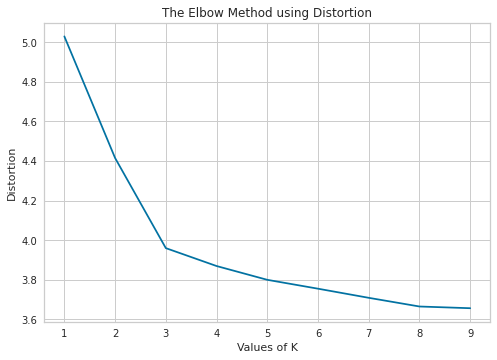

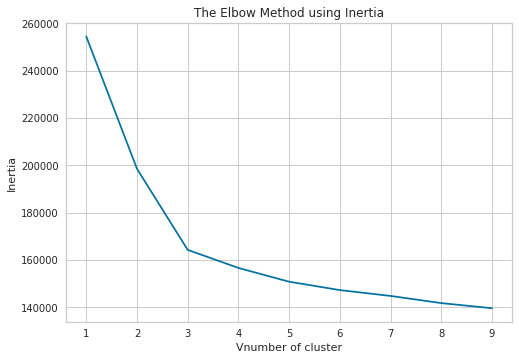


WE GET BEST KMEANS FOR K = 3



In [65]:
def Cluster_Data(dataset):
    #Find_Best_KMeans(dataset)
    #Find_Best_GMM(dataset)
    #Find_Best_Agglomerative(dataset)
    #Find_Best_DBScan(dataset)
    Silhouette_Clustering(dataset)
    
def Find_Best_KMeans(dataset):
    print("\n" + 20*"=" + "\nFind best KMeans:\n" + 20*"=")
    K = range(1, 10)
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    
    for k in K:
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k).fit(dataset)
    
        distortion_k = sum(np.min(cdist(dataset, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / dataset.shape[0]
        inertia_k = kmeanModel.inertia_
    
        distortions.append(distortion_k)
        inertias.append(inertia_k)
    
        mapping1[k] = distortion_k
        mapping2[k] = inertia_k
    
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method using Distortion')
    plt.savefig('images/elbow.png')
    plt.show()
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Vnumber of cluster')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method using Inertia')
    plt.show()

    print("\nWE GET BEST KMEANS FOR K = 3\n")


def Silhouette_Clustering(dataset):
    print("\n" + 20*"=" + "\nFind best Clustring:\n" + 20*"=")
    K = range(2, 11)
    a = [1,2]
    b = [2,3]
    c = [2,2]
    
    data = {'KMeans':a,'Agglomerative':b,'GMM':c}
    df = pd.DataFrame(data) 
    
    cmap = ListedColormap(['#0343df', '#e50000', '#ffff14', '#929591'])
    ax = df.plot.bar( colormap=cmap)
    ax.set_xlabel(None)
    ax.set_ylabel('Seats')
    ax.set_title('UK election results')

    plt.show()
    
    #for k in range(1):
        # Building and fitting the model
    #    KMeansModel_labels = KMeans(n_clusters=k).fit(dataset).predict(dataset)
    #    x = silhouette_score(dataset, KMeansModel_labels)
    #    silhouette_avg_vec.append(x)

Find_Best_KMeans(data)


In [9]:
k_cluser = 10
def run_kmeans(n_clusters, data):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
    return kmeans.labels_

def run_lle(num_neighbors, dims, mthd, data):
    embed_lle = LLE(n_neighbors=num_neighbors,n_components=dims,reg=0.001,method=mthd)
    return embed_lle.fit_transform(data)

def run_mds(n_components,metric,data):
    embedding = MDS(n_components=n_components,metric=metric,max_iter=100, n_init=1)
    return embedding.fit_transform(data)
    
def run_isomap(n_components,data):
    return Isomap(n_components=n_components).fit_transform(data)

def run_SpectralEmbedding(n_components, data):
    return SpectralEmbedding(n_components=n_components).fit_transform(data)

def run_agglomerative(n_clusters, data):
    aggloclust=AgglomerativeClustering(n_clusters=n_clusters).fit(data)
    AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5)
    return aggloclust.labels_

def run_gmm(n_components, data):
    return GMM(n_components=n_components).fit(data).predict(data)

def sqr_uniform_distance(dist):
    mean_dist = sum(dist)/(len(dist)-1) # don't count outliers as a class
    relevant_sqr_distances = [(d-mean_dist)**2 for d in dist[1:]]
    return sum(relevant_sqr_distances)

def tune_dbscan(data, num_of_classes=10):
    min_dbscan = None
    min_dist = float('inf')
    
    for eps in range(800,1600,4):
        eps = eps/100.0
        for n_samples in range(5,105):
            dbscan = DBSCAN(eps=eps, min_samples=n_samples).fit(data)
            labels = dbscan.labels_
            unique,counts = np.unique(labels,return_counts=True)
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)          
            if n_clusters_ == num_of_classes:
                if sqr_uniform_distance(counts) < min_dist:
                    min_dist = sqr_uniform_distance(counts)
                    min_dbscan = dbscan
                    return (eps,n_samples)
    return (0,0)

def find_param_dbscan(data, num_of_classes=10):
    dbscan = tune_dbscan(data, num_of_classes)
    print(dbscan)
    return {'eps':dbscan.eps,'min_samples': dbscan.min_samples}

def run_dbscan(n_components, data):
    neighbors = NearestNeighbors(n_neighbors=60)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    return DBSCAN(eps=3.7,min_samples=5).fit(data).labels_

#return DBSCAN(eps=3.53,min_samples=6) = 6
#DBSCAN(eps=3.83,min_samples=7) = 7
#DBSCAN(eps=3.98,min_samples=6) = 5
#DBSCAN(eps=3.6,min_samples=3).fit(data).labels_ = 11
#DBSCAN(eps=3.8,min_samples=3) = 8
#DBSCAN(eps=4.3,min_samples=2) = 14
#[(5,3.83,7),(6,3.53.6),(7,3.83,7),(8,3.8,3),(11,3.6,3),(14,4.3,2)]
#epsilons = []
#for i in range(4,9):
#    print(i)
#    k_cluster = i
#    epsilons.append(tune_dbscan(data,k_cluster))
labels = run_dbscan(k_cluster,data)
print(np.unique(labels,return_counts=True))
#result_tsne = run_tsne(2,data)
#(fig,axs) = print_fig(1,2)
#fig.axes[0] = add_fig(result_tsne,labels,"tsne",k_cluster,axs[0])
#plt.show()

NameError: name 'k_cluster' is not defined

In [208]:
print(epsilons)

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


In [10]:
def run_pca(n_components, data):
    pca = PCA(n_components=n_components)
    result = pca.fit_transform(data)
    return result

def run_tsne(n_components,data):
    tsne = TSNE(n_components = n_components)
    return tsne.fit_transform(data)

In [50]:
dataset = pd.read_csv("USCensus1990.data.txt")
external_variables = dataset[["dAge", "dHispanic", "iSex", "iYearwrk"]]
data_to_cluster = dataset.drop(["caseid", "dAge", "dHispanic", "iSex", "iYearwrk"], axis=1).astype(str)

In [51]:
print(data_to_cluster.iloc[1])
onehot_encoder = OneHotEncoder()
external_variables_np = external_variables.to_numpy()
data_to_cluster_np = data_to_cluster.sample(n=10000).values
onehot_encoded = onehot_encoder.fit_transform(data_to_cluster_np).toarray()
print(data_to_cluster_np[0])

dAncstry1    1
dAncstry2    1
iAvail       0
iCitizen     0
iClass       7
            ..
iWork89      1
iWorklwk     1
iWWII        0
iYearsch     5
dYrsserv     0
Name: 1, Length: 64, dtype: object
['11' '1' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '2' '0' '4' '0' '0' '0' '2' '0' '0' '0' '0' '0'
 '2' '0' '4' '0' '2' '0' '121' '0' '0' '1' '0' '10' '1' '0' '0' '2' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '4' '0']


In [52]:
size = 10000
k_cluster = 10
data = onehot_encoded[0:size]

In [82]:
df_s = find_data(data[indexes])
print(df)


dbscan
kmeans
agglomerative
gmm
2
dbscan
kmeans
agglomerative
gmm
3
dbscan
kmeans
agglomerative
gmm
4
dbscan
kmeans
agglomerative
gmm
5
dbscan
kmeans
agglomerative
gmm
6
dbscan
kmeans
agglomerative
gmm
7
dbscan
kmeans
agglomerative
gmm
8
dbscan
kmeans
agglomerative
gmm
9
dbscan
kmeans
agglomerative
gmm
10
dbscan
kmeans
agglomerative
gmm
11
dbscan
kmeans
agglomerative
gmm
12
dbscan
kmeans
agglomerative
gmm
13
dbscan
kmeans
agglomerative
gmm
14
     k    KMeans  Agglomerative       GMM    DBScan
0    2  0.209028       0.218352  0.217018  0.000000
1    3  0.236307       0.236009  0.236110  0.079817
2    4  0.214126       0.211259  0.189537  0.099476
3    5  0.182630       0.168679  0.177674  0.086621
4    6  0.180949       0.172217  0.115295  0.028968
5    7  0.154276       0.162291  0.098692  0.000000
6    8  0.089042       0.158149  0.137973  0.084865
7    9  0.088057       0.088330  0.078225  0.000000
8   10  0.089961       0.091528  0.058498  0.000000
9   11  0.099574       0.074800  

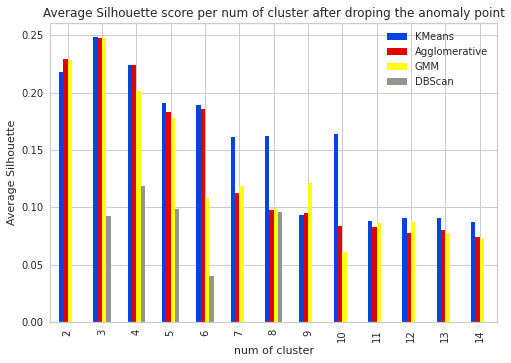

In [83]:
cmap = ListedColormap(['#0343df', '#e50000', '#ffff14', '#929591'])

ax = df_s.plot.bar(x='k',colormap=cmap)

ax.set_xlabel("num of cluster")
ax.set_ylabel('Average Silhouette')
ax.set_title('Average Silhouette score per num of cluster after droping the anomaly point')
plt.savefig('images/silhouette-anomaly.png')
plt.show()

hi


/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


hii


/usr/local/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:322: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


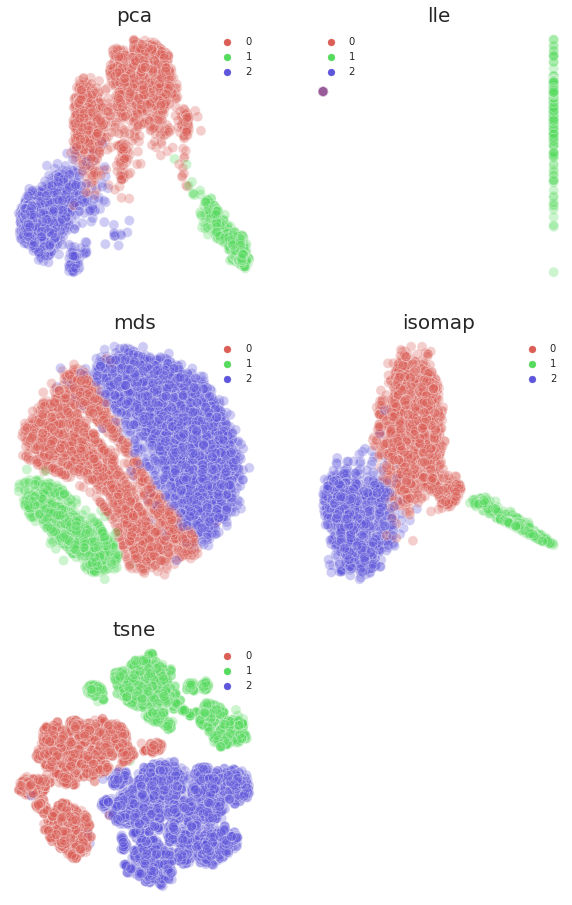

<Figure size 720x1152 with 0 Axes>

<Figure size 720x1152 with 0 Axes>

<Figure size 720x1152 with 0 Axes>

<Figure size 720x1152 with 0 Axes>

<Figure size 720x1152 with 0 Axes>

In [66]:
k_cluster = 3
labels = run_agglomerative(k_cluster,data)
result_pca = run_pca(2,data)
result_lle = run_lle(12,2,'standard',data)
print("hi")
result_tsne = run_tsne(2,data)
result_mds = run_mds(2,True,data)
#result_se = run_SpectralEmbedding(2,data)
print("hii")
result_isomap = run_isomap(2,data)
(fig,axs) = print_fig(3,2)
fig.axes[0] = add_fig(result_pca,labels,"pca",k_cluster,axs[0][0])
fig.axes[1] = add_fig(result_lle,labels,"lle",k_cluster,axs[0][1])
fig.axes[2] = add_fig(result_mds,labels,"mds",k_cluster,axs[1][0])
fig.axes[3] = add_fig(result_isomap,labels,"isomap",k_cluster,axs[1][1])
fig.axes[4] = add_fig(result_tsne,labels,"tsne",k_cluster,axs[2][0])
fig.axes[5].axis('off')
fig.axes[0].axis('off')
fig.axes[1].axis('off')
fig.axes[2].axis('off')
fig.axes[3].axis('off')
fig.axes[4].axis('off')
fig.savefig('images/agglomerative.png')
plt.show()
#Cluster_With_External_Variables(data_to_cluster_np, external_variables_np)


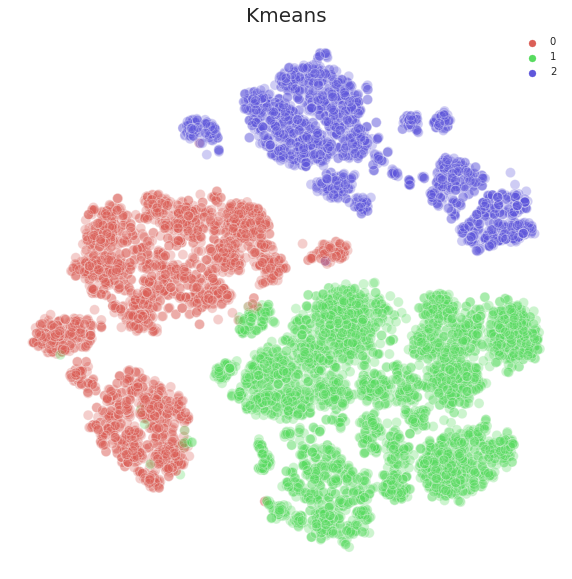

<Figure size 720x720 with 0 Axes>

In [144]:
(fig,axs) = print_fig(1,1)
#fig.axes[0] = add_fig(result_tsne,labels,"Tsne",k_cluster,axs)
#fig.axes[0] = add_fig(result_tsne,labels_dbscan,"DBScan",4,axs)
fig.axes[0] = add_fig(result_tsne,labels_kmeans,"Kmeans",k_cluster,axs)
#fig.axes[0] = add_fig(result_tsne,labels_gmm,"GMM",k_cluster,axs)
fig.axes[0].axis('off')
fig.savefig('images/kmeans.png')
plt.show()

In [94]:
print(np.unique(DBSCAN(eps=3.9,min_samples=30).fit(data).labels_,return_counts=True))
l = [(3,3.9,80),(4,3.9,110),(5,3.9,65),(6,3.9,55),(8,3.5,8)]
fig.axes[0].axis('off')

(array([-1,  0,  1,  2]), array([3359, 4189, 2148,  304]))


(-88.033931350708, 75.71786842346191, -83.2277328491211, 92.4069320678711)

4


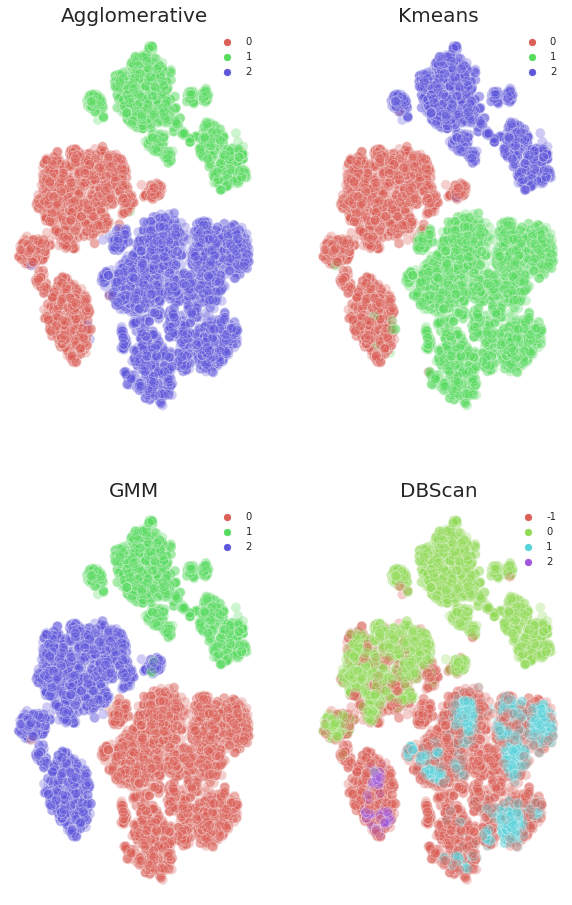

<Figure size 720x1152 with 0 Axes>

<Figure size 720x1152 with 0 Axes>

<Figure size 720x1152 with 0 Axes>

<Figure size 720x1152 with 0 Axes>

In [76]:
k_cluster = 3
#result_tsne = run_tsne(2,data)
labels_agglomerative = run_agglomerative(k_cluster,data)
labels_kmeans = run_kmeans(k_cluster,data)
labels_gmm = run_gmm(k_cluster,data)
labels_dbscan = DBSCAN(eps=3.9,min_samples=30).fit(data).labels_
labels_dbscan_size = len(np.unique(labels_dbscan,return_counts=True)[0])
print(labels_dbscan_size)
(fig,axs) = print_fig(2,2)
fig.axes[0] = add_fig(result_tsne,labels_agglomerative,"Agglomerative",k_cluster,axs[0][0])
fig.axes[1] = add_fig(result_tsne,labels_kmeans,"Kmeans",k_cluster,axs[0][1])
fig.axes[2] = add_fig(result_tsne,labels_gmm,"GMM",k_cluster,axs[1][0])
fig.axes[3] = add_fig(result_tsne,labels_dbscan,"DBScan",4,axs[1][1])
fig.axes[0].axis('off')
fig.axes[1].axis('off')
fig.axes[2].axis('off')
fig.axes[3].axis('off')
fig.savefig('images/t-sne_clustering.png')
plt.show()
#Cluster_With_External_Variables(data_to_cluster_np, external_variables_np)


In [155]:
dataset = pd.read_csv("USCensus1990.data.txt")
print("hi")
onehot_encoder = OneHotEncoder()
data_to_cluster_np_e = dataset.sample(n=1000)
data_to_cluster_np_e_value = data_to_cluster_np_e.values
data_to_cluster_external_e = data_to_cluster_np_e[["caseid", "dAge", "dHispanic", "iSex", "iYearwrk"]]
data_to_cluster_e = data_to_cluster_np_e.drop(["caseid", "dAge", "dHispanic", "iSex", "iYearwrk"], axis=1)
onehot_encoded_e = onehot_encoder.fit_transform(data_to_cluster_np_e_value).toarray()


hi


/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


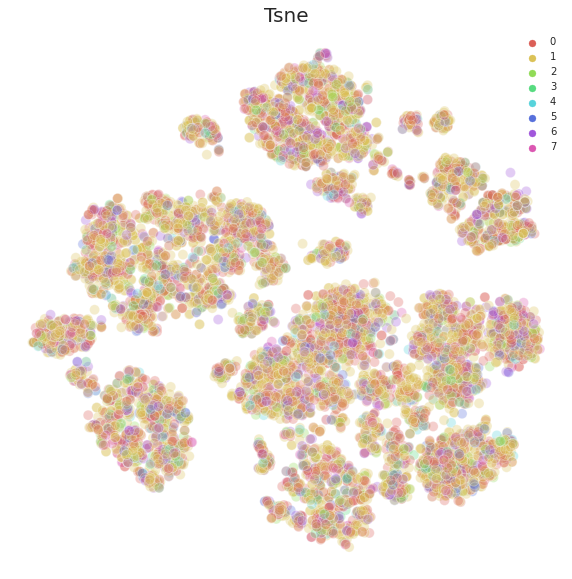

<Figure size 720x720 with 0 Axes>

In [153]:
(fig,axs) = print_fig(1,1)
result_tsne_va = run_tsne(2,data)
k_cluster = 3
#fig.axes[0] = add_fig(result_tsne,labels,"Tsne",k_cluster,axs)
#fig.axes[0] = add_fig(result_tsne,labels_dbscan,"DBScan",4,axs)
fig.axes[0] = add_fig(result_tsne,np.array(data_to_cluster_external_e['iYearwrk']),"Tsne",len(np.unique(np.array(data_to_cluster_external_e['iYearwrk']),return_counts=True)[0]),axs)
#fig.axes[0] = add_fig(result_tsne,labels_gmm,"GMM",k_cluster,axs)
fig.axes[0].axis('off')
fig.savefig('images/tnse-variable-iYearwrk.png')
plt.show()

In [183]:
kmeans_hc_kwargs = {'n_clusters': 3}
df_data = {'type':['PCA','MDS','IsoMAP','TSNE','LLE','SpectralEmbedding'],"data":[]}
types = ["dAge", "dHispanic", "iSex", "iYearwrk"]
gmm_kwargs = {'n_components': 3}


labels = np.array(data_to_cluster_external_e['dAge'])
result_pca = run_pca(2,onehot_encoded_e)
result_lle = run_lle(12,2,'standard',onehot_encoded_e)
result_tsne = run_tsne(2,onehot_encoded_e)
result_mds = run_mds(2,True,onehot_encoded_e)
result_se = run_SpectralEmbedding(2,onehot_encoded_e)
result_isomap = run_isomap(2,onehot_encoded_e)
print(labels)
print(run_experiment(AgglomerativeClustering,result_pca,labels,**kmeans_hc_kwargs))
df_data['data'].append(run_experiment(AgglomerativeClustering,result_pca,labels,**kmeans_hc_kwargs))
df_data['data'].append(run_experiment(AgglomerativeClustering,result_mds,labels,**kmeans_hc_kwargs))
df_data['data'].append(run_experiment(AgglomerativeClustering,result_isomap,labels,**kmeans_hc_kwargs))
df_data['data'].append(run_experiment(AgglomerativeClustering,result_tsne,labels,**kmeans_hc_kwargs))
df_data['data'].append(run_experiment(AgglomerativeClustering,result_lle,labels,**kmeans_hc_kwargs))
df_data['data'].append(run_experiment(AgglomerativeClustering,result_se,labels,**kmeans_hc_kwargs))



/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[5 5 6 5 4 6 7 4 1 4 3 1 7 7 6 5 3 4 6 4 0 5 1 2 6 7 2 2 2 2 2 7 7 2 5 3 1
 5 7 6 7 4 3 6 5 6 1 3 7 2 7 5 0 6 4 2 4 7 5 4 7 3 0 3 6 1 4 2 2 4 1 1 7 1
 7 4 4 1 7 4 7 6 1 0 4 5 5 1 4 3 3 7 5 5 5 4 6 7 2 7 4 5 2 5 3 3 6 5 3 3 7
 3 7 5 1 1 6 1 0 7 3 5 7 1 5 2 6 7 3 0 0 7 3 6 4 1 5 1 6 1 7 3 2 1 7 6 3 0
 7 4 3 3 2 0 4 7 5 3 4 5 5 1 5 7 1 4 4 4 7 6 1 5 4 4 2 1 5 4 4 5 3 7 5 3 3
 7 7 1 7 1 2 1 2 2 5 1 5 4 2 2 0 7 0 2 1 1 1 6 4 3 5 6 3 3 6 5 6 4 5 5 7 2
 6 2 4 5 6 7 1 5 5 3 4 6 3 4 4 1 4 0 4 3 7 7 6 5 6 7 6 5 6 3 5 2 1 6 4 7 6
 6 7 7 6 5 1 6 7 6 3 7 3 1 7 1 6 1 5 4 2 1 1 4 7 2 1 1 5 5 4 5 1 7 3 4 1 1
 2 1 1 5 6 1 4 5 7 7 4 6 4 6 7 6 1 1 1 5 7 5 4 3 1 6 5 1 3 3 1 4 6 7 1 1 1
 4 3 2 4 1 1 7 3 5 7 6 1 2 1 3 5 6 6 3 5 6 0 4 6 1 3 7 3 7 1 3 6 5 7 6 1 4
 7 5 3 6 2 2 6 3 1 2 2 4 3 1 1 1 4 0 2 3 1 6 5 7 2 6 6 5 6 7 5 4 5 2 4 7 6
 4 5 7 4 6 5 4 1 3 6 3 3 7 4 5 5 7 6 4 5 1 6 6 1 7 3 1 6 2 1 5 5 5 2 7 3 2
 0 7 4 5 2 4 4 1 6 5 3 7 4 6 2 7 2 1 3 7 4 1 2 5 3 4 7 4 4 3 4 2 3 0 1 5 1
 4 5 0 4 4 2 1 2 7 7 7 1 

{'type': ['PCA', 'MDS', 'IsoMAP', 'TSNE', 'LLE', 'SpectralEmbedding'], 'data': [0.93327774584008, 0.6804655314214576, 0.950823383823384, 0.937091593718727, 0.9421766916878896, 0.9416205004087976]}


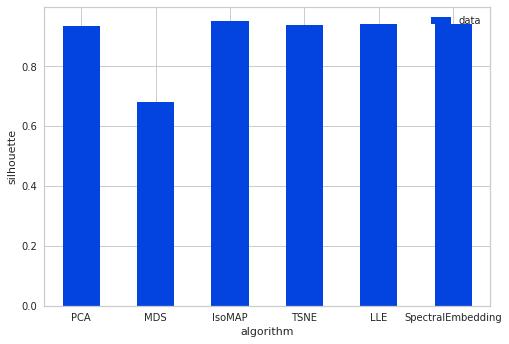

In [178]:
print(df_data)
df = pd.DataFrame(df_data)

cmap = ListedColormap(['#0343df', '#e50000', '#ffff14', '#929591'])
ax = df.plot.bar(x='type',colormap=cmap)
#ax.axes.xaxis.set_visible(False)
plt.xticks(rotation=0)
ax.set_ylabel('silhouette')
ax.set_xlabel('algorithm')
#ax.set_title('Average silhouette per algorithm with ')
plt.savefig('images/iYearwrk-compare.png')
plt.show()

In [184]:
F_anova, p_anova = f_oneway(np.array(df_data['data'])[0],np.array(df_data['data'])[1],np.array(df_data['data'])[2],np.array(df_data['data'])[3],np.array(df_data['data'])[4],np.array(df_data['data'])[5])
print(F_anova)
print(p_anova)
print("")

F_ttest,p_ttest = ttest_ind(np.array(df_data['data'])[2],np.array(df_data['data'])[3])
print(p_ttest)
#print("---")

4.353562476342061
0.0011570481199293923

0.5072800449658125


In [137]:
kmeans_hc_kwargs = {'n_clusters': 3}
df_data = {'type':['KMeans','AgglomerativeClustering','GMM'],"dAge":[], "dHispanic":[], "iSex":[], "iYearwrk":[]}
types = ["dAge", "dHispanic", "iSex", "iYearwrk"]
gmm_kwargs = {'n_components': 3}

#print(onehot_encoded_e[:][0])
for type_featuers in types:
#df_d = pd.DataFrame(d)
    gmm_mi = run_experiment(GMM, onehot_encoded_e[indexes]  ,np.array(data_to_cluster_external_e[type_featuers]),True, **gmm_kwargs)
    kmeans_mi = run_experiment(KMeans, onehot_encoded_e[indexes]  ,np.array(data_to_cluster_external_e[type_featuers]), **kmeans_hc_kwargs)
    hc_silhouette = run_experiment(AgglomerativeClustering, onehot_encoded_e[indexes]  ,np.array(data_to_cluster_external_e[type_featuers]), **kmeans_hc_kwargs)
    df_data[type_featuers].append(kmeans_mi)
    df_data[type_featuers].append(hc_silhouette)
    df_data[type_featuers].append(gmm_mi)

print(df_data)


#print(data_to_cluster_external_e.iloc[0])

hi


KeyboardInterrupt: 

In [125]:
#print(np.array(df_data['dAge'])[0],np.array(df_data['dAge'])[3])
#for type_featuers in types:
#    F_anova, p_anova = f_oneway(np.array(df_data[type_featuers])[0],np.array(df_data[type_featuers])[1],np.array(df_data[type_featuers])[2],np.array(df_data[type_featuers])[3])
#    print(F_anova)
#    print(p_anova)
    #F_ttest,p_ttest = ttest_ind(kmeans_mi,hc_mi)
    #print(F_ttest)
    #print(p_ttest)

for i in range(0,4):
    F_anova, p_anova = f_oneway(np.array(df_data[types[i]])[0],np.array(df_data[types[i]])[1],np.array(df_data[types[i]])[2])
    print(F_anova)
    print(p_anova)
    print("")
    
    F_ttest,p_ttest = ttest_ind(np.array(df_data[types[i]])[0],np.array(df_data[types[i]])[1])
    print(p_ttest)
    print("---")
    

2.966651849154323
0.05947552176870075

0.1179438156229631
---
0.6937182462284628
0.503883643509595

0.37852333080769673
---
5.451016871323952
0.0068198386088400564

0.9827789789709607
---
1.58456784258528
0.21393451460947693

0.004023280916309516
---


                      type      dAge  dHispanic      iSex  iYearwrk
0                   KMeans  0.583684   0.025565  0.030397  0.927318
1  AgglomerativeClustering  0.589658   0.024155  0.033937  0.918622
2                      GMM  0.586823   0.021375  0.046868  0.910909


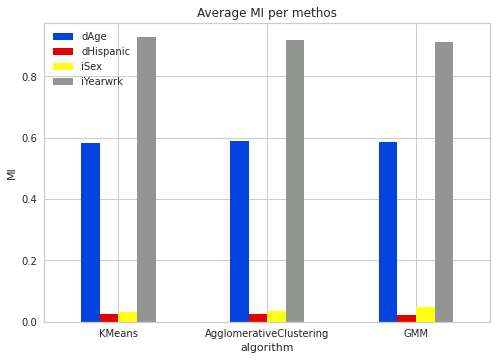

In [124]:
#df = pd.DataFrame(df_data)
print(df)
cmap = ListedColormap(['#0343df', '#e50000', '#ffff14', '#929591'])
ax = df.plot.bar(x='type',colormap=cmap)
#ax.axes.xaxis.set_visible(False)
plt.xticks(rotation=0)
ax.set_ylabel('MI')
ax.set_xlabel('algorithm')
ax.set_title('Average MI per methos')
plt.savefig('images/MI-ext.png')
plt.show()

In [100]:
kmeans_hc_kwargs = {'n_clusters': 3}
gmm_kwargs = {'n_components': 3}

dbscan_kwargs = {'eps': 3.9, 'min_samples':30}
dbscan_silhouette = silhouette(DBSCAN, data, **dbscan_kwargs)


gmm_silhouette = Silhouette_gmm(GMM, data, **gmm_kwargs)

kmeans_silhouette = silhouette(KMeans, data, **kmeans_hc_kwargs)
#kmeans_mi = run_experiment(KMeans, data, **kmeans_hc_kwargs)

hc_silhouette = silhouette(AgglomerativeClustering, data, **kmeans_hc_kwargs)
#hc_mi = run_experiment(AgglomerativeClustering, data, **kmeans_hc_kwargs)


For n_clusters = 10 The average silhouette_score is : 0.0741812829574649
hi
For n_clusters = 10 The average silhouette_score is : 0.23610957701084453
For n_clusters = 10 The average silhouette_score is : 0.23630676767514106
For n_clusters = 10 The average silhouette_score is : 0.23600911080004558


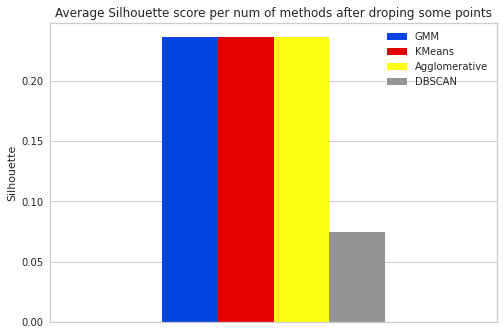

In [103]:
data_s = {'GMM':[gmm_silhouette],'KMeans':[kmeans_silhouette],'Agglomerative':[hc_silhouette],'DBSCAN':[dbscan_silhouette]}
df = pd.DataFrame(data_s)
cmap = ListedColormap(['#0343df', '#e50000', '#ffff14', '#929591'])

ax = df.plot.bar(colormap=cmap)

ax.axes.xaxis.set_visible(False)
ax.set_ylabel('Silhouette')
ax.set_title('Average Silhouette score per num of methods after droping some points')
plt.savefig('images/avg_silhouette.png')
plt.show()

array([-1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,
        0, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

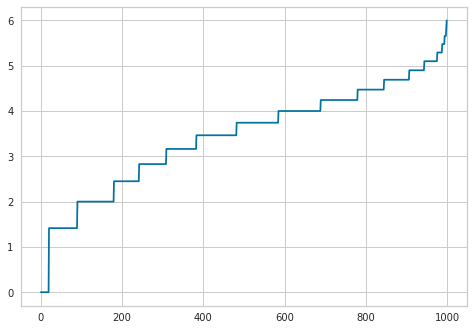

In [136]:
plt.savefig('images/agglomerative.png')

In [132]:
indexes = [i for i,x in enumerate(labels) if x == 2]
print(len(indexes))

4533


In [138]:
contamination = 0.1
epochs = 30

clf = AutoEncoder(epochs=epochs, contamination=contamination)
clf.fit(onehot_encoded_e)

y_train_pred = clf.labels_  
y_train_scores = clf.decision_scores_ 



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 10388)             107920932 
                                                                 
 dropout_6 (Dropout)         (None, 10388)             0         
                                                                 
 dense_8 (Dense)             (None, 10388)             107920932 
                                                                 
 dropout_7 (Dropout)         (None, 10388)             0         
                                                                 
 dense_9 (Dense)             (None, 64)                664896    
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)               


KeyboardInterrupt



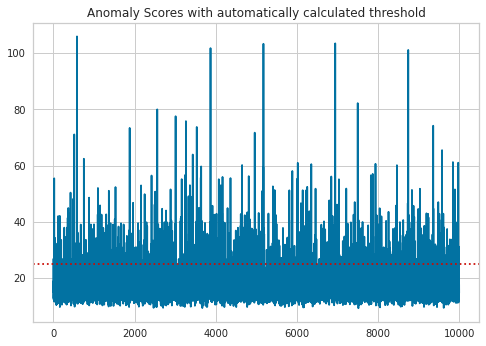

1000


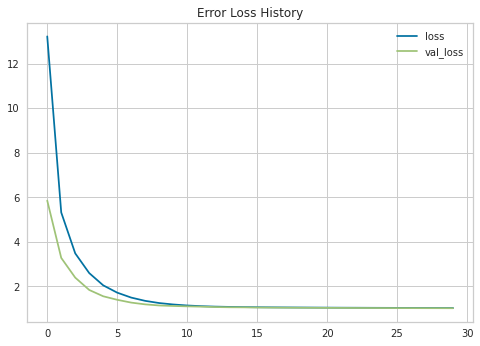

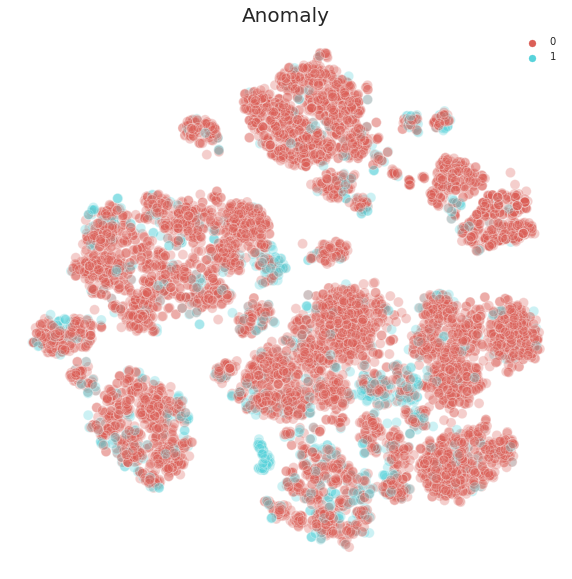

<Figure size 720x720 with 0 Axes>

In [133]:
plt.plot(y_train_scores)

#axs[i][j%5].plot(y_train_scores);
plt.axhline(y=clf.threshold_, c='r', ls='dotted', label='threshoold');
plt.title('Anomaly Scores with automatically calculated threshold');
plt.show()
pd.DataFrame.from_dict(clf.history_).plot(title='Error Loss History');
print(sum(y_train_pred))
(fig,axs) = print_fig(1,1)
indexes = [i for i,x in enumerate(y_train_pred) if x == 0]
fig.axes[0] = add_fig(result_tsne,y_train_pred,"Anomaly",2,axs)
fig.axes[0].axis('off')

plt.show()
fig.savefig('images/anomaly.png')

9000
[-1  0  1  2]
4


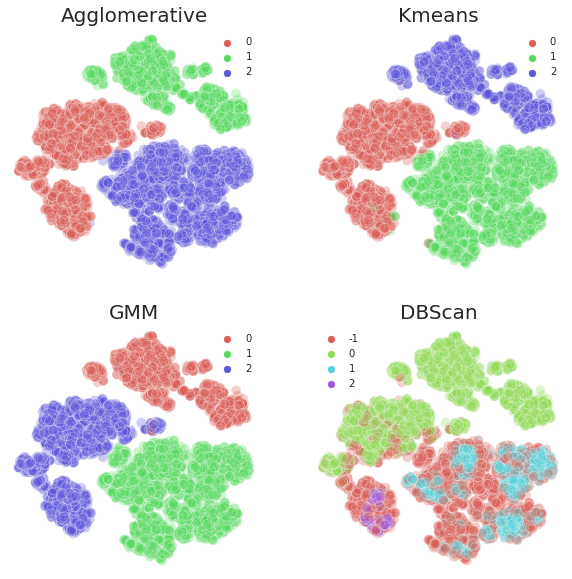

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [135]:
k_cluster = 3
indexes = [i for i,x in enumerate(y_train_pred) if x == 0]
print(len(indexes))
data_new = data[indexes]
#result_tsne = run_tsne(2,data)
labels_agglomerative = run_agglomerative(k_cluster,data)
labels_kmeans = run_kmeans(k_cluster,data)
labels_gmm = run_gmm(k_cluster,data)
labels_dbscan = DBSCAN(eps=3.9,min_samples=30).fit(data).labels_
labels_dbscan_size = len(np.unique(labels_dbscan,return_counts=True)[0])
print(np.unique(labels_dbscan,return_counts=True)[0])
print(labels_dbscan_size)
(fig,axs) = print_fig(2,2)
fig.axes[0] = add_fig(result_tsne[indexes],labels_agglomerative[indexes],"Agglomerative",k_cluster,axs[0][0])
fig.axes[1] = add_fig(result_tsne[indexes],labels_kmeans[indexes],"Kmeans",k_cluster,axs[0][1])
fig.axes[2] = add_fig(result_tsne[indexes],labels_gmm[indexes],"GMM",k_cluster,axs[1][0])
fig.axes[3] = add_fig(result_tsne[indexes],labels_dbscan[indexes],"DBScan",4,axs[1][1])
fig.axes[0].axis('off')
fig.axes[1].axis('off')
fig.axes[2].axis('off')
fig.axes[3].axis('off')
fig.savefig('images/t-sne_clustering-anomaly-droping.png')
plt.show()

In [494]:
# AuthEncoder - anomaly detection
contamination = 0.1 
epochs = 30
clf = []
for j in range(1,10):
    clf_temp = AutoEncoder(epochs=epochs, contamination=contamination)
    indexes = [i for i,x in enumerate(labels) if x == j]
    clf_temp.fit(data[indexes])
    clf.append(clf_temp)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 364)               132860    
                                                                 
 dropout_6 (Dropout)         (None, 364)               0         
                                                                 
 dense_8 (Dense)             (None, 364)               132860    
                                                                 
 dropout_7 (Dropout)         (None, 364)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                23360     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)               

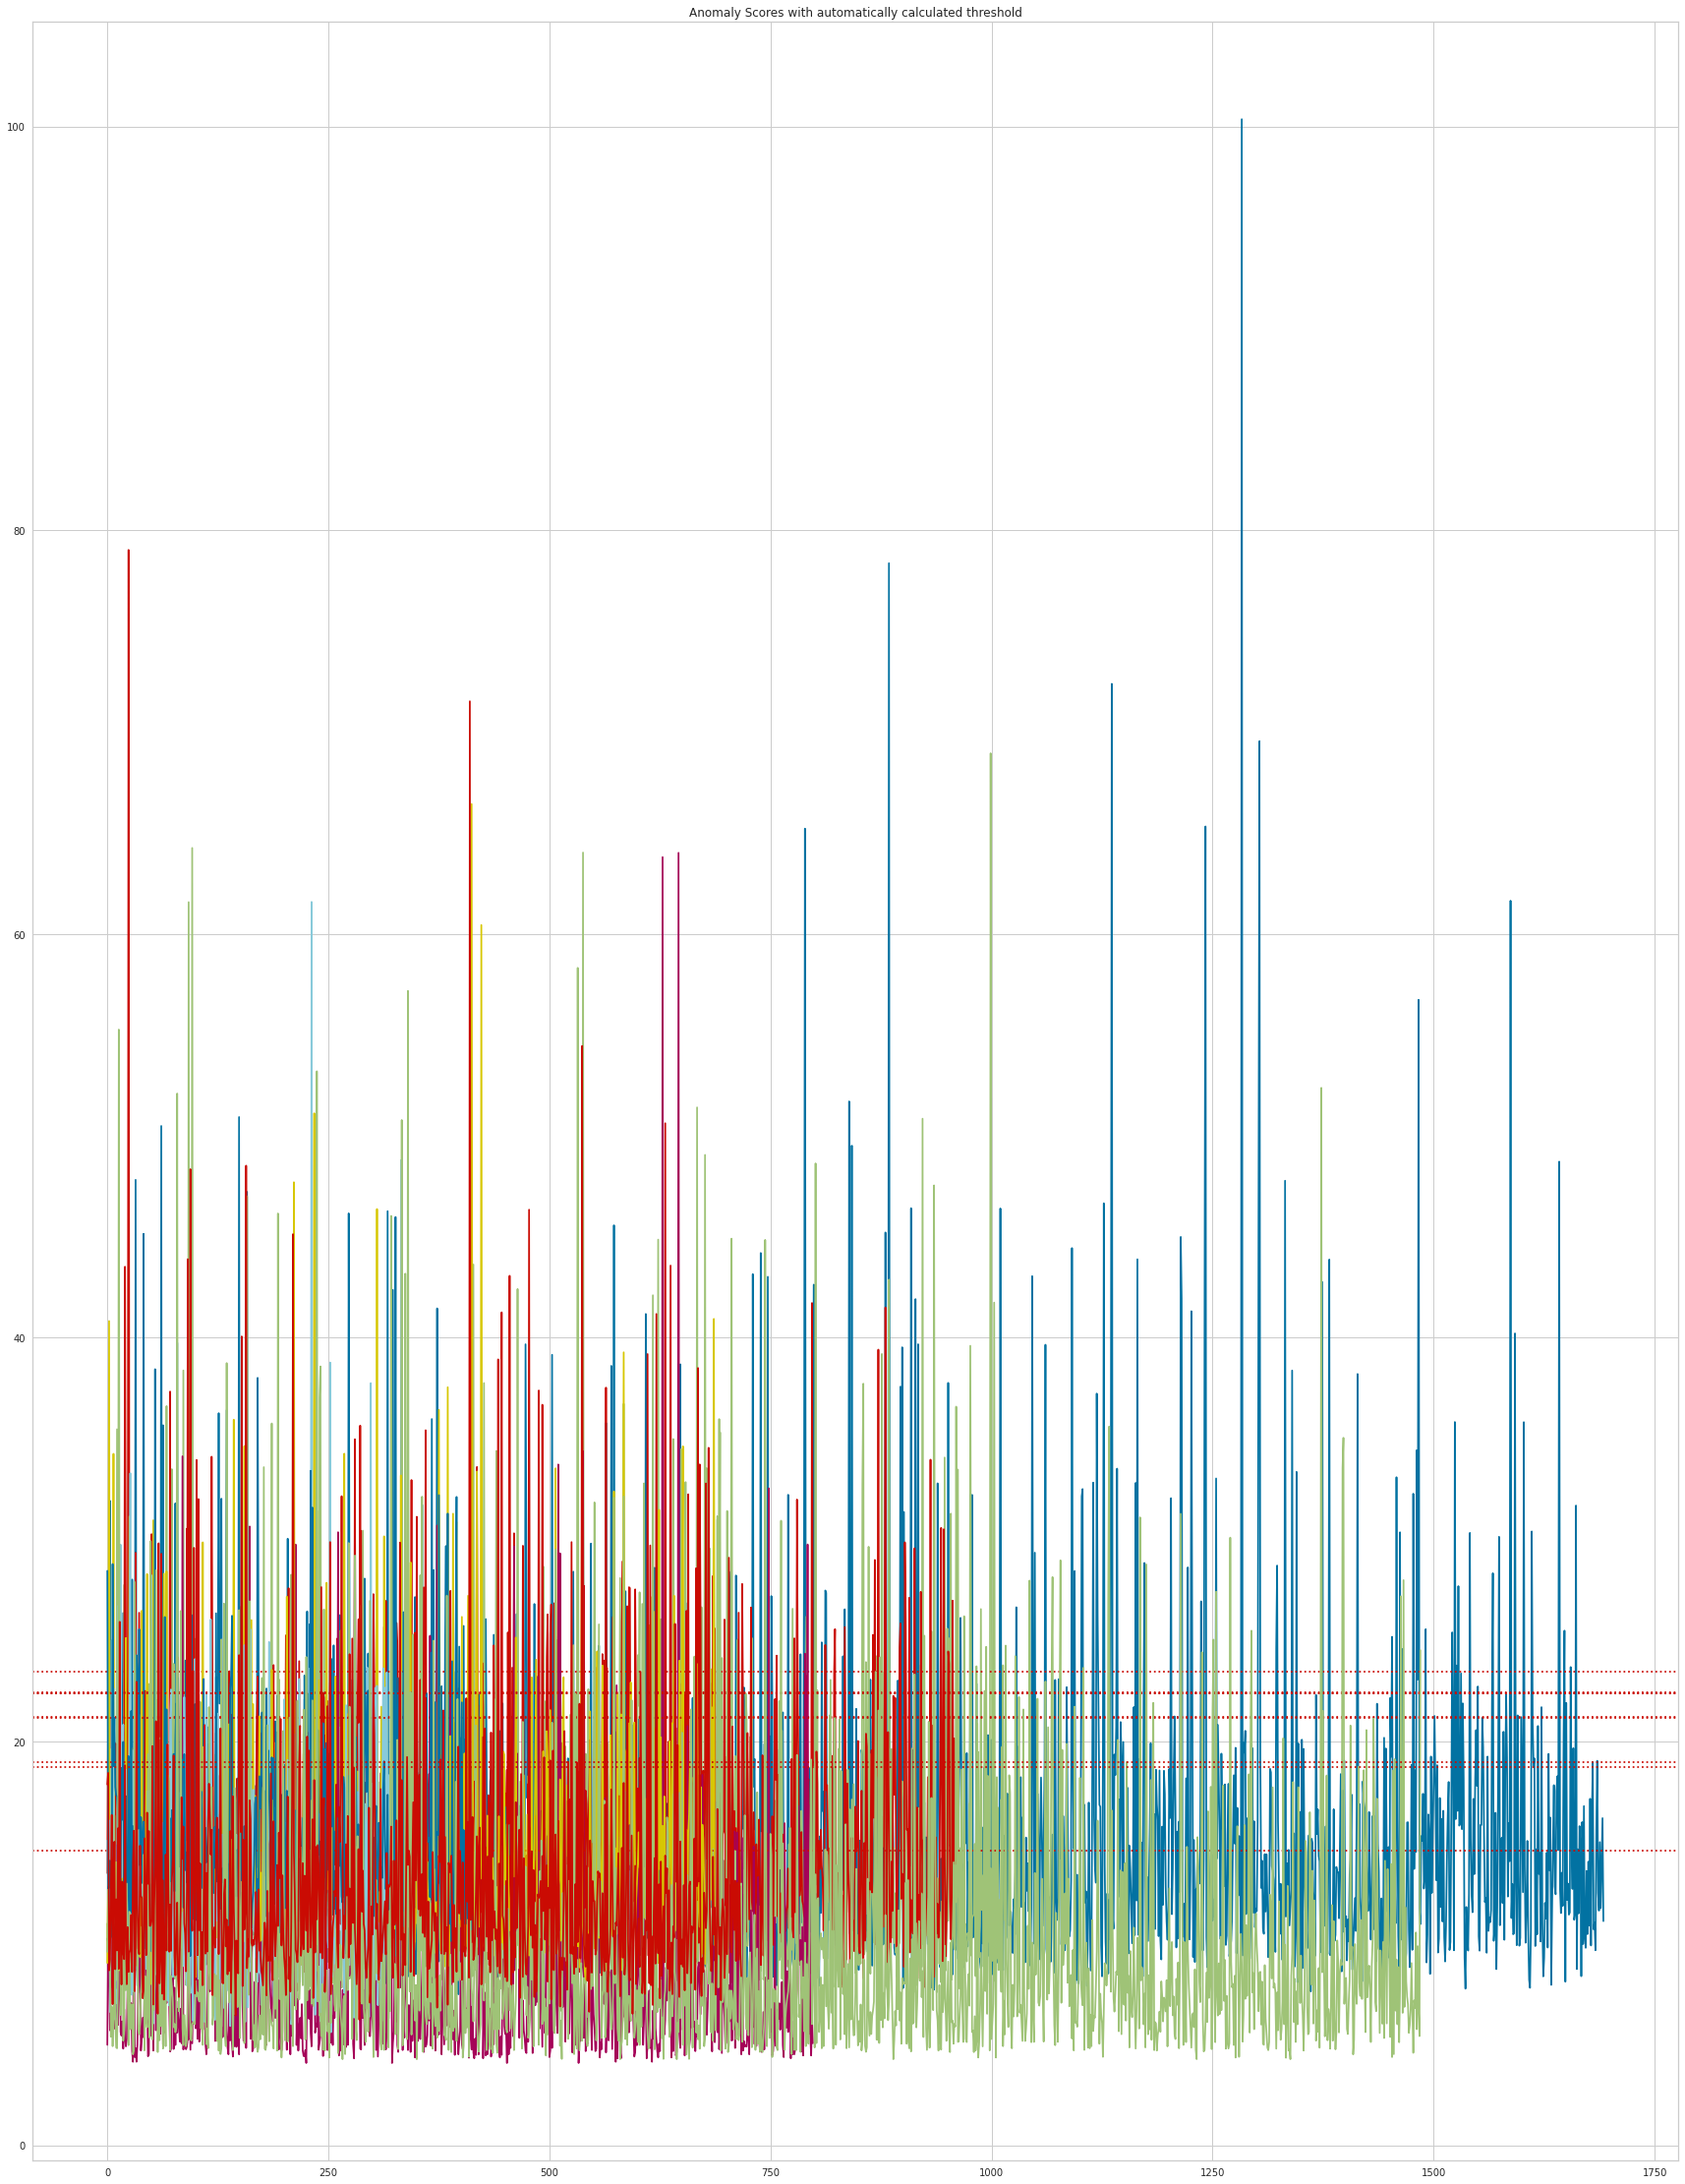

In [530]:
i = 0
(fig,axs) = print_fig(1,1)
for j in range(0,9):
    y_train_pred = clf[j].labels_  
    y_train_scores = clf[j].decision_scores_ 

    fig.axes[i] = plt.plot(y_train_scores)
    #axs[i][j%5].plot(y_train_scores);
    fig.axes[i].axhline(y=clf[j].threshold_, c='r', ls='dotted', label='threshoold');
    fig.axes[i].set_title('Anomaly Scores with automatically calculated threshold');
plt.show()